# Reddit Social Network Analysis
#### DataRes Research - Winter 2023

## Import libraries, packages, env

In [1]:
# !pip3 install colab-env
# !pip3 install praw
# !pip3 install torch
# !pip3 install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cu117.html

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
CUDA = 12.0

In [4]:
import argparse
import os, sys 
import os.path as osp
from typing import Callable, List, Optional

# Reddit API
import praw

# General
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import copy

import scipy.sparse as sp

from sklearn.metrics import accuracy_score

from tqdm import tqdm

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.nn import (
    ModuleList,
    Linear,
)
from torch.nn.functional import dropout, relu

from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
    extract_zip,
    DataLoader,
    NeighborSampler,
)
from torch_geometric.utils import (
    coalesce,
    to_networkx,
    train_test_split_edges,
    add_self_loops, 
    degree,
)
from torch_geometric.nn import (
    GAT, 
    GATConv,
    SAGEConv,
    global_max_pool,
    global_mean_pool,
    MessagePassing,
)

import torch_geometric.transforms as T

from torch_geometric.logging import init_wandb, log

from torch_geometric.loader import NeighborLoader, DataLoader

from torch_geometric.datasets import Reddit

In [6]:
print(torch.__version__)

1.13.1+cu117


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path = 'Datasets'

dataset = Reddit(path, transform=None)

# if not os.path.exists(path):
#     dataset = Reddit(path, transform=None)
# else:
#     # Dataset already exists, so skip creating it
#     print('Dataset already exists at', path)
#     dataset = torch.load('Datasets/processed/data.pt')

In [8]:
dataset

Reddit()

In [9]:
dataset[0]

Data(x=[232965, 602], edge_index=[2, 114615892], y=[232965], train_mask=[232965], val_mask=[232965], test_mask=[232965])

# Reddit Dataset EDA

In [10]:
dataset

Reddit()

In [11]:
dataset[0].x

tensor([[ 1.2334,  9.0430, -0.9233,  ..., -0.2579,  0.3112, -0.3772],
        [-0.1386, -0.2022,  0.1277,  ...,  0.1563,  0.1048, -0.6534],
        [-0.1330, -0.1962, -0.0296,  ...,  0.0358,  0.2864,  0.2744],
        ...,
        [-0.0614, -0.2022,  0.9698,  ...,  1.1064, -1.4323, -0.2398],
        [-0.1606, -0.2022, -0.0892,  ...,  0.7440, -0.5046, -2.2288],
        [ 0.0929,  0.2822,  0.1768,  ...,  0.2196,  0.5967,  0.5588]])

In [12]:
dataset[0].edge_index.shape

torch.Size([2, 114615892])

In [13]:
dataset[0].edge_index.t().numpy()

array([[     0,    242],
       [     0,    249],
       [     0,    524],
       ...,
       [232964, 231806],
       [232964, 232594],
       [232964, 232634]])

In [14]:
dataset[0].edge_index.t().numpy().shape

(114615892, 2)

In [15]:
# Get the number of nodes and edges in the dataset
num_nodes = dataset[0].num_nodes
num_edges = dataset[0].num_edges

# Print some information about the dataset
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

# # Get the node features as a numpy array
node_features = dataset[0].x.numpy()

# # Plot a histogram of the node features
# plt.hist(node_features.flatten(), bins='auto')
# plt.title("Histogram of Node Features")
# plt.xlabel("Node Feature Value")
# plt.ylabel("Frequency")
# plt.show()
# plt.close()

del node_features

Number of nodes: 232965
Number of edges: 114615892


In [16]:
# Compute the sparsity of the adjacency matrix
edge_index = dataset[0].edge_index
adjacency_matrix = sp.coo_matrix((torch.ones(num_edges), edge_index), shape=(num_nodes, num_nodes))
sparsity = 1 - (num_edges / (num_nodes * (num_nodes - 1)))
print("Adjacency matrix sparsity:", sparsity)

# # Plot the adjacency matrix
# plt.spy(adjacency_matrix, markersize=0.1)
# plt.title("Adjacency Matrix")
# plt.xlabel("Node ID")
# plt.ylabel("Node ID")
# plt.show()

del edge_index, adjacency_matrix, sparsity

Adjacency matrix sparsity: 0.9978881389258081


In [17]:
# Community of graph 0
dataset[0].y

tensor([30, 17, 18,  ...,  3, 13, 13])

In [18]:
# Subreddits (one-hot encoded) of graph 0
num_subreddits = dataset.num_classes
print(num_subreddits)
dataset[0].x[:, :num_subreddits]

41


tensor([[ 1.2334,  9.0430, -0.9233,  ..., -1.2256, -0.3788, -1.3944],
        [-0.1386, -0.2022,  0.1277,  ...,  0.6615,  0.5723,  0.2782],
        [-0.1330, -0.1962, -0.0296,  ..., -0.6425,  1.1302, -1.7275],
        ...,
        [-0.0614, -0.2022,  0.9698,  ..., -0.7903, -0.6344, -2.5713],
        [-0.1606, -0.2022, -0.0892,  ...,  0.0801,  0.7868,  0.2527],
        [ 0.0929,  0.2822,  0.1768,  ...,  0.4616, -0.7446,  0.6888]])

# Node Classification Models

In [19]:
# Already send node features/labels to GPU for faster access during sampling:
data = dataset[0].to(device, 'x', 'y')

kwargs = {'batch_size': 512, 'num_workers': 6, 'persistent_workers': True}
train_loader = NeighborLoader(data, input_nodes=data.train_mask,
                              num_neighbors=[25, 10], shuffle=True, **kwargs)

subgraph_loader = NeighborLoader(copy.copy(data), input_nodes=None,
                                 num_neighbors=[-1], shuffle=False, **kwargs)

# No need to maintain these features during evaluation:
del subgraph_loader.data.x, subgraph_loader.data.y

# Add global node index information.
subgraph_loader.data.num_nodes = data.num_nodes
subgraph_loader.data.n_id = torch.arange(data.num_nodes)

## SAGE

In [20]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = x.relu_()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    @torch.no_grad()
    def inference(self, x_all, subgraph_loader):
        pbar = tqdm(total=len(subgraph_loader.dataset) * len(self.convs))
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch:
        for i, conv in enumerate(self.convs):
            xs = []
            for batch in subgraph_loader:
                x = x_all[batch.n_id.to(x_all.device)].to(device)
                x = conv(x, batch.edge_index.to(device))
                if i < len(self.convs) - 1:
                    x = x.relu_()
                xs.append(x[:batch.batch_size].cpu())
                pbar.update(batch.batch_size)
            x_all = torch.cat(xs, dim=0)
        pbar.close()
        return x_all

In [21]:
model = SAGE(dataset.num_features, 256, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [22]:
def train(epoch):
    model.train()

    pbar = tqdm(total=int(len(train_loader.dataset)))
    pbar.set_description(f'Epoch {epoch:02d}')

    total_loss = total_correct = total_examples = 0
    for batch in train_loader:
        optimizer.zero_grad()
        y = batch.y[:batch.batch_size]
        y_hat = model(batch.x, batch.edge_index.to(device))[:batch.batch_size]
        loss = F.cross_entropy(y_hat, y)
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * batch.batch_size
        total_correct += int((y_hat.argmax(dim=-1) == y).sum())
        total_examples += batch.batch_size
        pbar.update(batch.batch_size)
    pbar.close()

    return total_loss / total_examples, total_correct / total_examples

In [23]:
@torch.no_grad()
def test():
    model.eval()
    y_hat = model.inference(data.x, subgraph_loader).argmax(dim=-1)
    y = data.y.to(y_hat.device)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((y_hat[mask] == y[mask]).sum()) / int(mask.sum()))
    return accs

In [24]:
sage_train_accs, sage_val_accs, sage_test_accs = [], [], []

for epoch in range(1, 11):
    loss, acc = train(epoch)
    print(f'Epoch {epoch:02d}, Loss: {loss:.4f}, Approx. Train: {acc:.4f}')
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:02d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')

    # store accuracy values for SAGE
    sage_train_accs.append(train_acc)
    sage_val_accs.append(val_acc)
    sage_test_accs.append(test_acc)
    
    # delete intermediate tensors
    del loss, acc, train_acc, val_acc, test_acc

Epoch 01: 100%|██████████| 153431/153431 [00:05<00:00, 29826.91it/s]


Epoch 01, Loss: 1.7085, Approx. Train: 0.6054


Evaluating: 100%|██████████| 465930/465930 [00:20<00:00, 22740.99it/s]


Epoch: 01, Train: 0.8607, Val: 0.8728, Test: 0.8672


Epoch 02: 100%|██████████| 153431/153431 [00:04<00:00, 35275.86it/s]


Epoch 02, Loss: 0.5583, Approx. Train: 0.8760


Evaluating: 100%|██████████| 465930/465930 [00:20<00:00, 22780.65it/s]


Epoch: 02, Train: 0.9325, Val: 0.9371, Test: 0.9355


Epoch 03: 100%|██████████| 153431/153431 [00:04<00:00, 35705.81it/s]


Epoch 03, Loss: 0.3764, Approx. Train: 0.9152


Evaluating: 100%|██████████| 465930/465930 [00:20<00:00, 22679.30it/s]


Epoch: 03, Train: 0.9430, Val: 0.9476, Test: 0.9451


Epoch 04: 100%|██████████| 153431/153431 [00:04<00:00, 35020.20it/s]


Epoch 04, Loss: 0.3133, Approx. Train: 0.9275


Evaluating: 100%|██████████| 465930/465930 [00:22<00:00, 20743.52it/s]


Epoch: 04, Train: 0.9482, Val: 0.9511, Test: 0.9490


Epoch 05: 100%|██████████| 153431/153431 [00:04<00:00, 34457.14it/s]


Epoch 05, Loss: 0.2789, Approx. Train: 0.9339


Evaluating: 100%|██████████| 465930/465930 [00:20<00:00, 22920.90it/s]


Epoch: 05, Train: 0.9521, Val: 0.9541, Test: 0.9526


Epoch 06: 100%|██████████| 153431/153431 [00:04<00:00, 35205.69it/s]


Epoch 06, Loss: 0.2568, Approx. Train: 0.9373


Evaluating: 100%|██████████| 465930/465930 [00:21<00:00, 22059.94it/s]


Epoch: 06, Train: 0.9543, Val: 0.9558, Test: 0.9542


Epoch 07: 100%|██████████| 153431/153431 [00:04<00:00, 34052.95it/s]


Epoch 07, Loss: 0.2397, Approx. Train: 0.9417


Evaluating: 100%|██████████| 465930/465930 [00:22<00:00, 20441.96it/s]


Epoch: 07, Train: 0.9561, Val: 0.9570, Test: 0.9555


Epoch 08: 100%|██████████| 153431/153431 [00:04<00:00, 35335.88it/s]


Epoch 08, Loss: 0.2259, Approx. Train: 0.9443


Evaluating: 100%|██████████| 465930/465930 [00:23<00:00, 19738.68it/s]


Epoch: 08, Train: 0.9581, Val: 0.9578, Test: 0.9568


Epoch 09: 100%|██████████| 153431/153431 [00:04<00:00, 34478.68it/s]


Epoch 09, Loss: 0.2159, Approx. Train: 0.9459


Evaluating: 100%|██████████| 465930/465930 [00:23<00:00, 19710.68it/s]


Epoch: 09, Train: 0.9595, Val: 0.9588, Test: 0.9581


Epoch 10: 100%|██████████| 153431/153431 [00:04<00:00, 35437.64it/s]


Epoch 10, Loss: 0.2066, Approx. Train: 0.9477


Evaluating: 100%|██████████| 465930/465930 [00:29<00:00, 15793.56it/s]

Epoch: 10, Train: 0.9607, Val: 0.9597, Test: 0.9587


## Graph Attention Network (GAT)

In [25]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GATConv(in_channels, hidden_channels, heads=8, dropout=0.2))
        self.convs.append(GATConv(hidden_channels * 8, out_channels, heads=1, dropout=0.2))
        self.activation = nn.LeakyReLU()

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = self.activation(x)
        return x

    @torch.no_grad()
    def inference(self, x_all, subgraph_loader):
        pbar = tqdm(total=len(subgraph_loader.dataset) * len(self.convs))
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch:
        for i, conv in enumerate(self.convs):
            xs = []
            for batch in subgraph_loader:
                x = x_all[batch.n_id.to(x_all.device)].to(device)
                x = conv(x, batch.edge_index.to(device))
                if i < len(self.convs) - 1:
                    x = self.activation(x)
                xs.append(x[:batch.batch_size].cpu())
                pbar.update(batch.batch_size)
            x_all = torch.cat(xs, dim=0)
        pbar.close()
        return x_all

In [26]:
model = GAT(dataset.num_features, 128, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [27]:
def train(epoch):
    model.train()

    pbar = tqdm(total=int(len(train_loader.dataset)))
    pbar.set_description(f'Epoch {epoch:02d}')

    total_loss = total_correct = total_examples = 0
    for batch in train_loader:
        optimizer.zero_grad()
        y = batch.y[:batch.batch_size]
        y_hat = model(batch.x, batch.edge_index.to(device))[:batch.batch_size]
        loss = F.cross_entropy(y_hat, y)
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * batch.batch_size
        total_correct += int((y_hat.argmax(dim=-1) == y).sum())
        total_examples += batch.batch_size
        pbar.update(batch.batch_size)
    pbar.close()

    return total_loss / total_examples, total_correct / total_examples

In [28]:
@torch.no_grad()
def test():
    model.eval()
    y_hat = model.inference(data.x, subgraph_loader).argmax(dim=-1)
    y = data.y.to(y_hat.device)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((y_hat[mask] == y[mask]).sum()) / int(mask.sum()))
    return accs

In [29]:
gat_train_accs, gat_val_accs, gat_test_accs = [], [], []

for epoch in range(1, 11):
    loss, acc = train(epoch)
    print(f'Epoch {epoch:02d}, Loss: {loss:.4f}, Approx. Train: {acc:.4f}')
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:02d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')

    # store accuracy values for GAT
    gat_train_accs.append(train_acc)
    gat_val_accs.append(val_acc)
    gat_test_accs.append(test_acc)
    
    # delete intermediate tensors
    del loss, acc, train_acc, val_acc, test_acc

Epoch 01: 100%|██████████| 153431/153431 [00:13<00:00, 11130.66it/s]


Epoch 01, Loss: 1.3526, Approx. Train: 0.7096


Evaluating: 100%|██████████| 465930/465930 [00:59<00:00, 7871.19it/s] 


Epoch: 01, Train: 0.7631, Val: 0.7789, Test: 0.7846


Epoch 02: 100%|██████████| 153431/153431 [00:17<00:00, 8994.42it/s]


Epoch 02, Loss: 0.5967, Approx. Train: 0.8831


Evaluating: 100%|██████████| 465930/465930 [00:59<00:00, 7872.38it/s] 


Epoch: 02, Train: 0.8272, Val: 0.8399, Test: 0.8440


Epoch 03: 100%|██████████| 153431/153431 [00:19<00:00, 7872.86it/s] 


Epoch 03, Loss: 0.4745, Approx. Train: 0.9030


Evaluating: 100%|██████████| 465930/465930 [00:48<00:00, 9510.71it/s] 


Epoch: 03, Train: 0.8556, Val: 0.8649, Test: 0.8686


Epoch 04: 100%|██████████| 153431/153431 [00:12<00:00, 12017.65it/s]


Epoch 04, Loss: 0.4210, Approx. Train: 0.9112


Evaluating: 100%|██████████| 465930/465930 [00:56<00:00, 8296.65it/s] 


Epoch: 04, Train: 0.8670, Val: 0.8742, Test: 0.8763


Epoch 05: 100%|██████████| 153431/153431 [00:22<00:00, 6924.82it/s]


Epoch 05, Loss: 0.3934, Approx. Train: 0.9154


Evaluating: 100%|██████████| 465930/465930 [00:59<00:00, 7802.81it/s] 


Epoch: 05, Train: 0.8892, Val: 0.8933, Test: 0.8967


Epoch 06: 100%|██████████| 153431/153431 [00:12<00:00, 12023.22it/s]


Epoch 06, Loss: 0.3703, Approx. Train: 0.9193


Evaluating: 100%|██████████| 465930/465930 [01:12<00:00, 6424.63it/s] 


Epoch: 06, Train: 0.9042, Val: 0.9079, Test: 0.9105


Epoch 07: 100%|██████████| 153431/153431 [00:12<00:00, 11815.98it/s]


Epoch 07, Loss: 0.3558, Approx. Train: 0.9213


Evaluating: 100%|██████████| 465930/465930 [01:02<00:00, 7431.18it/s] 


Epoch: 07, Train: 0.9104, Val: 0.9134, Test: 0.9158


Epoch 08: 100%|██████████| 153431/153431 [00:12<00:00, 11946.77it/s]


Epoch 08, Loss: 0.3453, Approx. Train: 0.9233


Evaluating: 100%|██████████| 465930/465930 [00:53<00:00, 8748.37it/s] 


Epoch: 08, Train: 0.9153, Val: 0.9171, Test: 0.9201


Epoch 09: 100%|██████████| 153431/153431 [00:21<00:00, 6994.70it/s]


Epoch 09, Loss: 0.3339, Approx. Train: 0.9248


Evaluating: 100%|██████████| 465930/465930 [00:51<00:00, 8962.87it/s] 


Epoch: 09, Train: 0.9210, Val: 0.9246, Test: 0.9269


Epoch 10: 100%|██████████| 153431/153431 [00:12<00:00, 11927.34it/s]


Epoch 10, Loss: 0.3278, Approx. Train: 0.9254


Evaluating: 100%|██████████| 465930/465930 [01:00<00:00, 7678.83it/s] 

Epoch: 10, Train: 0.9287, Val: 0.9305, Test: 0.9328


## Accuracy Visualization

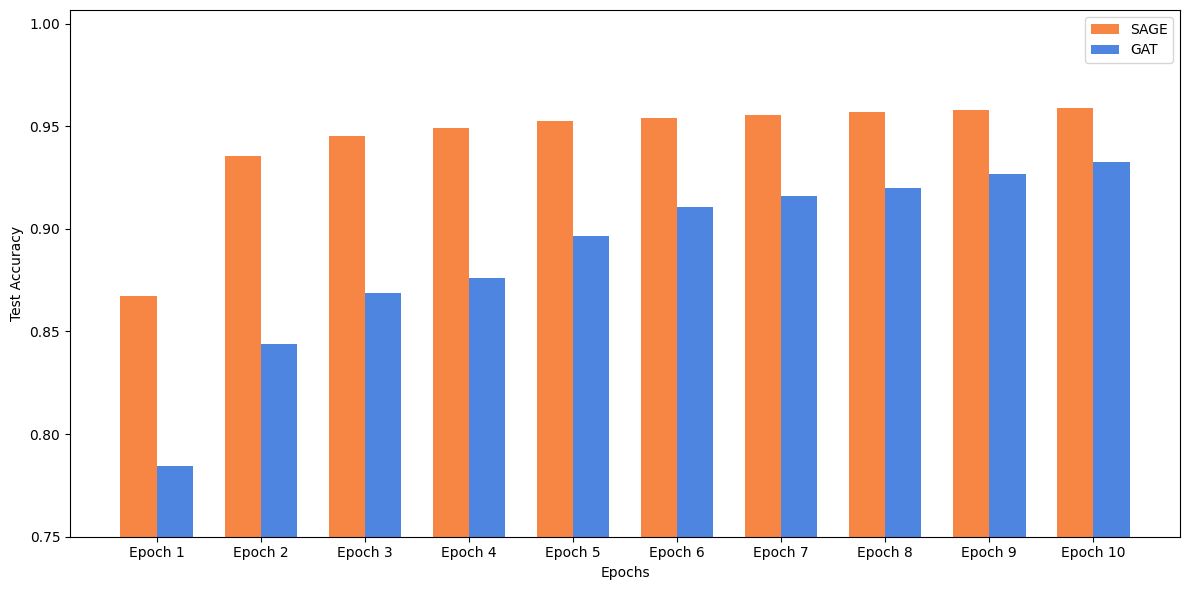

In [38]:
# create a list of labels for each epoch
epochs = range(1, 11)
epoch_labels = [f"Epoch {i}" for i in epochs]

# plot the comparison bar plot
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
opacity = 0.8
colors = ['#F66815', '#2267D9']

# shift the x coordinates for the second model
x = np.array(epochs)

ax.bar(x, sage_test_accs, bar_width, alpha=opacity, color=colors[0], label="SAGE")
ax.bar(x + bar_width, gat_test_accs, bar_width, alpha=opacity, color=colors[1], label="GAT")
ax.set_ylim(bottom=0.75)

ax.set_xlabel('Epochs')
ax.set_ylabel('Test Accuracy')
ax.set_xticks(np.array(epochs) + bar_width / 2)
ax.set_xticklabels(epoch_labels)
ax.legend()
plt.tight_layout()
plt.show()

# Data Collection

In [31]:
from dotenv import load_dotenv

In [32]:
load_dotenv()

reddit_client_id = os.getenv('reddit_client_id')
reddit_client_secret = os.getenv('reddit_client_secret')
reddit_user_agent = os.getenv('reddit_user_agent')

Data Extraction Code Reference from: https://colab.research.google.com/drive/15883QxK-f3Extq4dHRdqz1RdbgObzS_l?usp=sharing

In [33]:
#===========================================================================
# helper functions
#===========================================================================

#---------------------------------------------------------------------------
# get all new posts from a specific subreddit as a dataframe
def getNewPostsAsDF(r, subredditName, postLimit=10):
  df = pd.DataFrame()   
  subreddit = r.subreddit(subredditName) 
  for submission in subreddit.new(limit=postLimit):
    df = df.append({'subreddit': subredditName,
                  'post_id': submission.id,
                  'created': datetime.utcfromtimestamp(submission.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
                  'raw_title': submission.title,
                  'author': submission.author,
                  'karma': round(submission.score),
                  'awards': round(submission.total_awards_received),
                  'permalink': submission.permalink},
                 ignore_index = True)
  df['created'] = pd.to_datetime(df['created'], format='%Y-%m-%d %H:%M:%S')     
  return(df)


#---------------------------------------------------------------------------
# get all comments from a specific post as a dataframe
def getAllCommentsAsDF(r, submissionId):
  df = pd.DataFrame()   
  res = getAllComments(r, submissionId)
  for item in res:
      if type(item) == praw.models.reddit.comment.Comment:
          parent_id_clean = item.parent_id.replace("t1_","").replace("t3_","")
          if parent_id_clean==submissionId:
            parent_id_clean = ''
          df = df.append({'post_id':submissionId,
                          'comment_id': item.id,
                          'comment_parent_id': parent_id_clean,
                          'author': item.author,
                          'raw_comment': item.body,
                          'karma': round(item.score),
                          'awards': round(item.total_awards_received)},  
                  ignore_index = True)
  return(df)   

#---------------------------------------------------------------------------
# get all comments on this submission as praw objects in a list
# requires a submissionId, the id of the reddit post
def getAllComments(r, submissionId, verbose=True):
  submission = r.submission(submissionId)
  comments = submission.comments
  commentsList = []
  for comment in comments:
    getSubComments(comment, commentsList, verbose=verbose)
  return commentsList

#---------------------------------------------------------------------------
# recursive function to get nexted comments that replied to other comments
def getSubComments(comment, allComments, verbose=True):
  allComments.append(comment)
  if not hasattr(comment, "replies"):
    replies = comment.comments()
    if verbose: print("fetching (" + str(len(allComments)) + " comments fetched total)")
  else:
    replies = comment.replies
  for child in replies:
    getSubComments(child, allComments, verbose=verbose) 

In [34]:
# create a reddit instance using the API key
reddit = praw.Reddit(client_id=reddit_client_id,
                     client_secret=reddit_client_secret,
                     user_agent=reddit_user_agent)

In [35]:
#===========================================================================
# get the latest 500 hot posts from /r/UCLA
latest_posts = getNewPostsAsDF(reddit, "UCLA", 500)

# save as local CSV 
# latest_posts.to_csv('reddit_posts_UCLA.csv') 
# files.download('reddit_posts_UCLA.csv')

In [36]:
latest_posts

,subreddit,post_id,created,raw_title,author,karma,awards,permalink
0,UCLA,11ptbrv,2023-03-12 23:22:56,Neuroscience Upper Div Syllabus,Intrepid_Birthday651,1,0,/r/ucla/comments/11ptbrv/neuroscience_upper_di...
1,UCLA,11ptbl9,2023-03-12 23:22:43,NCAA tickets,Slyther1208,1,0,/r/ucla/comments/11ptbl9/ncaa_tickets/
2,UCLA,11psc5o,2023-03-12 22:43:22,Isn’t a swipe worth around $10? This sounds cr...,EitherNoise9180,2,0,/r/ucla/comments/11psc5o/isnt_a_swipe_worth_ar...
3,UCLA,11psan9,2023-03-12 22:41:41,whoa😩,tiredfml,2,0,/r/ucla/comments/11psan9/whoa/
4,UCLA,11prp3k,2023-03-12 22:17:56,Using someone else’s bruincard in dining halls,Every-Ad7132,1,0,/r/ucla/comments/11prp3k/using_someone_elses_b...
...,...,...,...,...,...,...,...,...
495,UCLA,11l8d1r,2023-03-07 19:16:08,is RSU down??,Ok_Garbage955,3,0,/r/ucla/comments/11l8d1r/is_rsu_down/
496,UCLA,11l7qcv,2023-03-07 18:52:47,Hitch Suite Looking to Swap for a University A...,jamjamtheyam,2,0,/r/ucla/comments/11l7qcv/hitch_suite_looking_t...
497,UCLA,11l7mmz,2023-03-07 18:48:49,6 hour clicc equipment,ShinkaiSparkle,1,0,/r/ucla/comments/11l7mmz/6_hour_clicc_equipment/
498,UCLA,11l7faf,2023-03-07 18:41:06,Emails for letters of rec,sss10215,8,0,/r/ucla/comments/11l7faf/emails_for_letters_of...
